* 1. Load the libries and Data For the project

In [462]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC,SVR
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor 

# Preprocessing
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn import preprocessing
# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

#Imputation
from fancyimpute import BiScaler, KNN

# Metrics


# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

#Load the data from csv
store = pd.read_csv('./input/store.csv')
train = pd.read_csv('./input/train.csv', parse_dates=["Date"],keep_date_col=True)
test = pd.read_csv('./input/test.csv', parse_dates=["Date"],keep_date_col=True)

#Data information Analysis including the data type and how many observations etc.
display(store.info())
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


None

In [497]:
#Create some helpers functions

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
def normalize(x):

    xmin = x.min()
    xmax = x.max()
    
    x = (x-xmin)/(xmax-xmin)

    return x

def rmspe_score(y_true,y_pred):
    return 'RMSPE',float(np.sqrt(np.mean((1-y_pred/y_true)**2)))

def minmaxscaler(df):
    return 

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def percentage_annotate_helper(ax,df):
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/len(df)), (x.mean(), y),
                       ha='center', va='bottom') # set the alignment of the text

def outliers_detector(df,feature):
    Q1 = np.percentile(df[feature],25) 
    Q2 = np.percentile(df[feature],50)
    Q3 = np.percentile(df[feature],75)
    step = 1.5 * (Q3-Q1)
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))])
    return df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))].index.values

def plotModelResults(model, X_train, X_test,y_test,plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmspe_score(y_test,prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(float(error[1])))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');


In [101]:
mask = train[(train.DayOfWeek!=7) & (train.Open==0) & (train.StateHoliday==0) & (train.SchoolHoliday==0)].groupby(train.Store).count()
display(mask[mask.Store>3])

display(train[(train.Store==390) & (train.DayOfWeek!=7) & (train.Open==0) & (train.StateHoliday==0) & (train.SchoolHoliday==0)])


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,,
25,21,21,21,21,21,21,21,21,21
123,6,6,6,6,6,6,6,6,6
145,5,5,5,5,5,5,5,5,5
227,11,11,11,11,11,11,11,11,11
357,12,12,12,12,12,12,12,12,12
376,8,8,8,8,8,8,8,8,8
390,4,4,4,4,4,4,4,4,4
623,4,4,4,4,4,4,4,4,4
708,30,30,30,30,30,30,30,30,30


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
561564,390,4,2014-02-13,0,0,0,0,0,0
562679,390,3,2014-02-12,0,0,0,0,0,0
563794,390,2,2014-02-11,0,0,0,0,0,0
564909,390,1,2014-02-10,0,0,0,0,0,0


In [72]:
#Data Clean up

#Check for some missing values
#print store.isnull().sum()
store['CompetitionDistance'].fillna(0,inplace=True)
store['Promo2SinceWeek'].fillna(0,inplace=True)
store['Promo2SinceYear'].fillna(0,inplace=True)
store['PromoInterval'].fillna('n',inplace=True)
store['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
store['CompetitionOpenSinceYear'].fillna(0,inplace=True)
#display(store[store['CompetitionDistance']==0].count())
#display(store[store['CompetitionOpenSinceMonth']==0].count())
#display(store[store['CompetitionOpenSinceYear']==0].count())
#print store.isnull().sum()

#store = pd.get_dummies(store,columns=['StoreType','Assortment','PromoInterval'])
#store[store['CompetitionOpenSinceMonth'].isnull()].head()
#sns.distplot(store['CompetitionOpenSinceYear'])

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


ValueError: cannot convert float NaN to integer

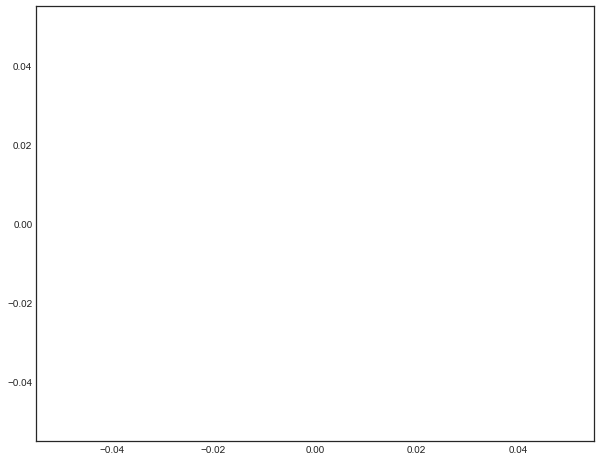

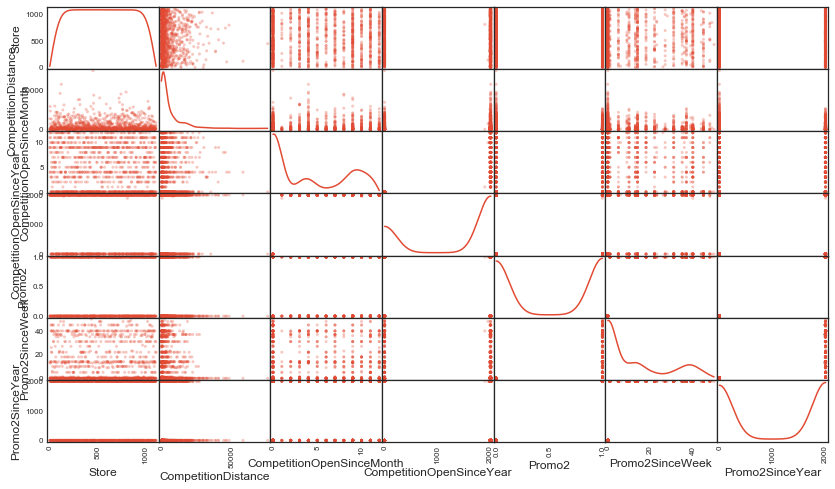

In [67]:
_,ax = plt.subplots(figsize=(10,8))
pd.plotting.scatter_matrix(store, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
#outliers_detector(store,'CompetitionDistance')
#store['Promo2SinceWeek'].describe()
#np.log1p(store['Promo2SinceWeek']).describe()

In [40]:
display(train.isnull.sum())

AttributeError: 'function' object has no attribute 'sum'

             Store  DayOfWeek  Sales  Customers  Open      Promo  \
count    52.000000  52.000000   52.0       52.0  52.0  52.000000   
mean    565.615385   3.730769    0.0        0.0   1.0   0.365385   
std     334.720788   1.315300    0.0        0.0   0.0   0.486236   
min      25.000000   1.000000    0.0        0.0   1.0   0.000000   
25%     321.000000   3.000000    0.0        0.0   1.0   0.000000   
50%     642.000000   4.000000    0.0        0.0   1.0   0.000000   
75%     858.000000   4.250000    0.0        0.0   1.0   1.000000   
max    1100.000000   6.000000    0.0        0.0   1.0   1.000000   

       SchoolHoliday  
count      52.000000  
mean        0.230769  
std         0.425436  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  


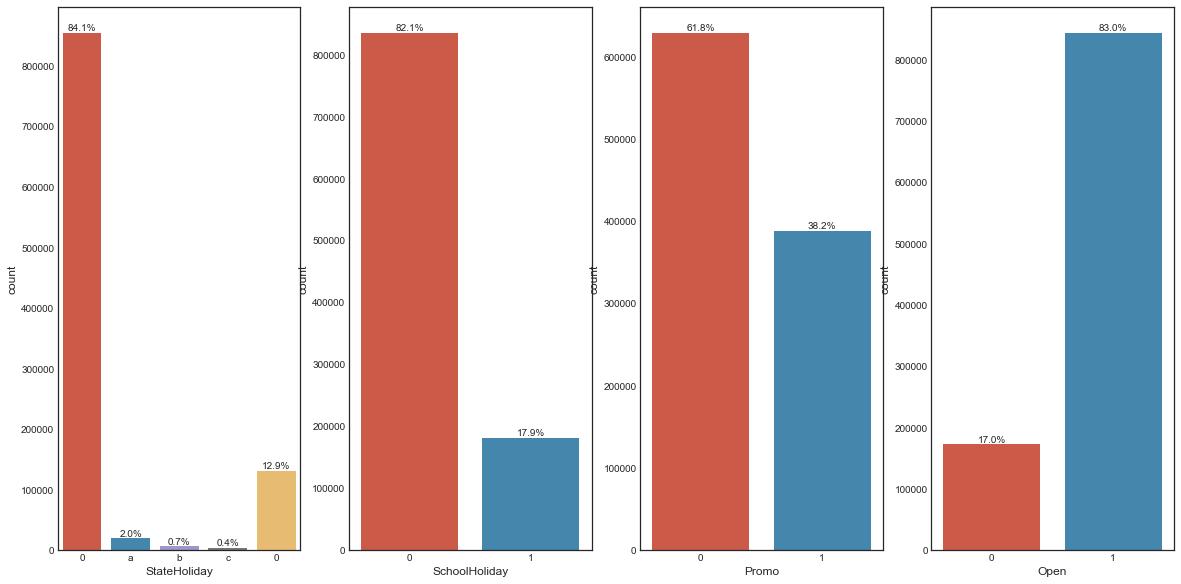

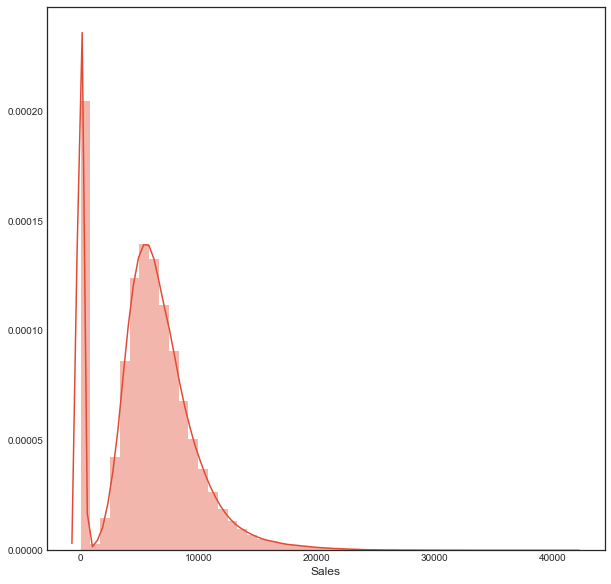

In [266]:
#print train.isnull().sum()
#print store.isnull().sum()

_,ax = plt.subplots(1,4,figsize=(20,10))

ax = ax.ravel()
#ax[0] = sns.barplot(x="StateHoliday", y="Values", data=train, estimator=lambda x: len(x) / len(train) * 100)
sns.countplot(data=train,x='StateHoliday',ax=ax[0])
percentage_annotate_helper(ax[0],train['StateHoliday'])
sns.countplot(data=train,x='SchoolHoliday',ax=ax[1])
percentage_annotate_helper(ax[1],train['SchoolHoliday'])
sns.countplot(data=train,x='Promo',ax=ax[2])
percentage_annotate_helper(ax[2],train['Promo'])
sns.countplot(data=train,x='Open',ax=ax[3])
percentage_annotate_helper(ax[3],train['Open'])

no_sales_with_customers = train.index[(train.Sales==0) & (train.Customers>0)].tolist()
#Drop rare cases
train.drop(no_sales_with_customers,inplace=True)

print train[(train.Sales==0) & (train.Open==1)].describe()

_,ax = plt.subplots(figsize=(10,10))
sns.distplot((train['Sales']),ax=ax)

#print store.columns
#index = store['CompetitionDistance'].index[store['CompetitionDistance'].apply(np.isnan)]
#print store.describe()
#store['CompetitionDistance'].fillna(0,inplace=True)
#store['PromoInterval'].fillna('no',inplace=True)

#print store[store['Promo2']==1].count()
#sns.countplot(data=store,x='StoreType',ax=ax[0,0])
#sns.countplot(data=store,x='Assortment',ax=ax[0,1])
#sns.countplot(data=store,x='PromoInterval',ax=ax[0,2])
#sns.countplot(data=store,x='')
#sns.distplot(store.Promo2)
#sns.distplot(store.CompetitionDistance,ax=ax[1,0])




In [449]:
train_data = pd.merge(train,store,on='Store')

#print train_data['Date'].head()
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data.set_index(train_data['Date'],inplace=True)
train_data['Month'] = train_data['Date'].map(lambda x: x.month)
train_data['Year'] = train_data['Date'].map(lambda x: x.year)
train_data['Week'] = train_data['Date'].map(lambda x: x.strftime("%V"))
train_data['Week']=pd.to_numeric(train_data['Week'], downcast='integer')
train_data['Season'] = train_data['Date'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4)))
train_data['CompetitionDistance'].fillna(0,inplace=True)
train_data["CompetitionMonthDuration"] = (train_data['Month']-train_data['CompetitionOpenSinceMonth'])+(train_data['Year']-train_data['CompetitionOpenSinceYear'])*12
train_data["Promo2WeekDuration"] = (train_data['Week']-train_data['Promo2SinceWeek'])/4+(train_data['Year']-train_data['Promo2SinceYear'])*12
train_data["CompetitionMonthDuration"].fillna(0,inplace=True)
train_data["Promo2WeekDuration"].fillna(0,inplace=True)
train_data['PromoInterval'].fillna('n',inplace=True)
#train_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear'],axis=1,inplace=True)

train_data['Sales'] = train_data['Sales']*1.0

#train_data.describe()

KeyError: 'Date'

In [ ]:
sns.factorplot(data = train_data, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'DayOfWeek',
               row = 'DayOfWeek')

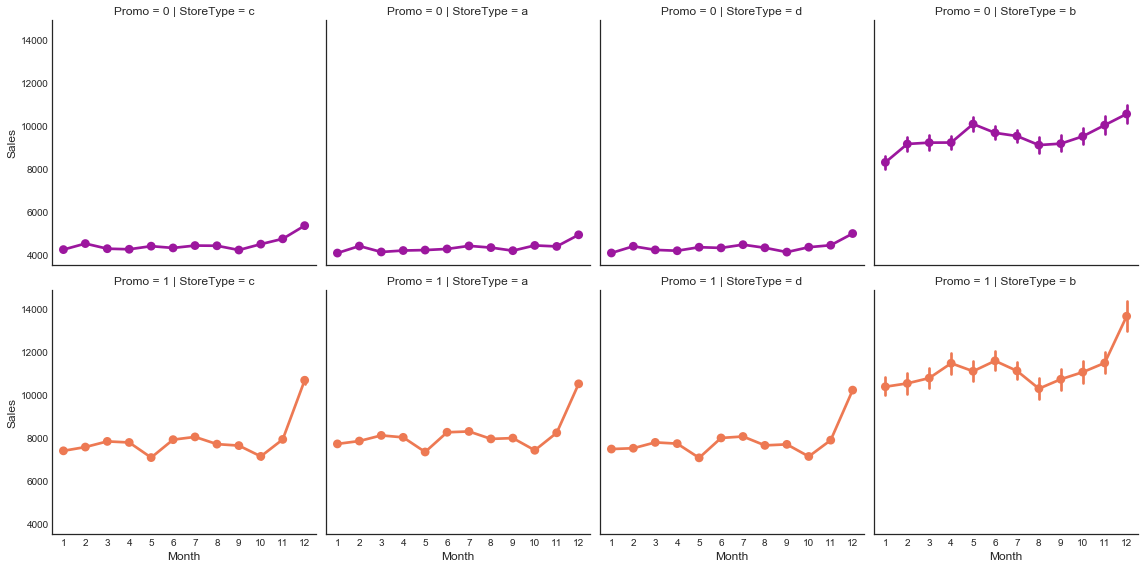

In [193]:
sns.factorplot(data = train_data, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'Promo',
               row = 'Promo')

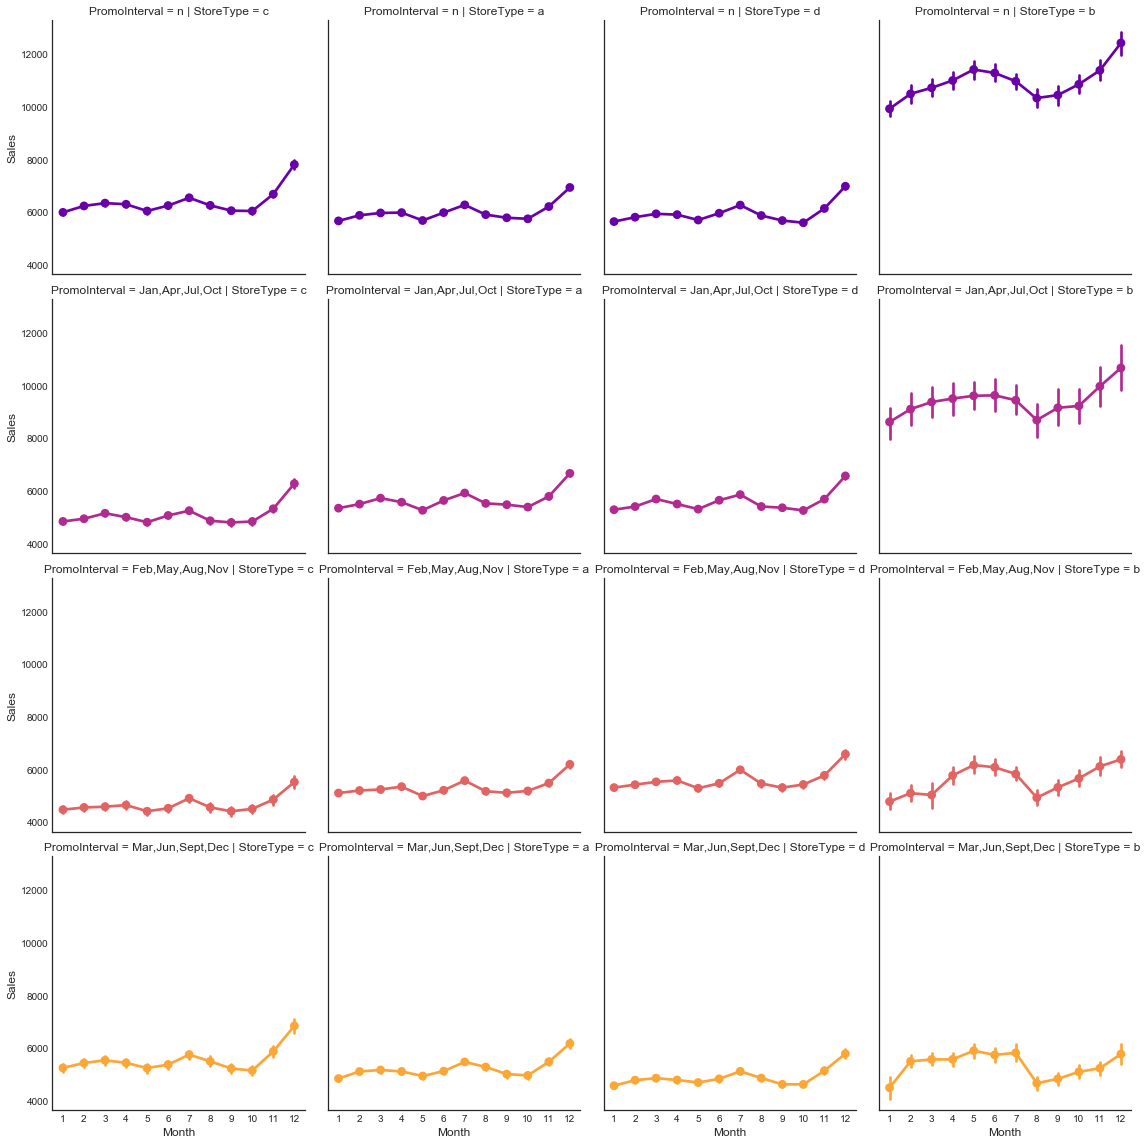

In [152]:
sns.factorplot(data = train_data, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'PromoInterval',
               row = 'PromoInterval')

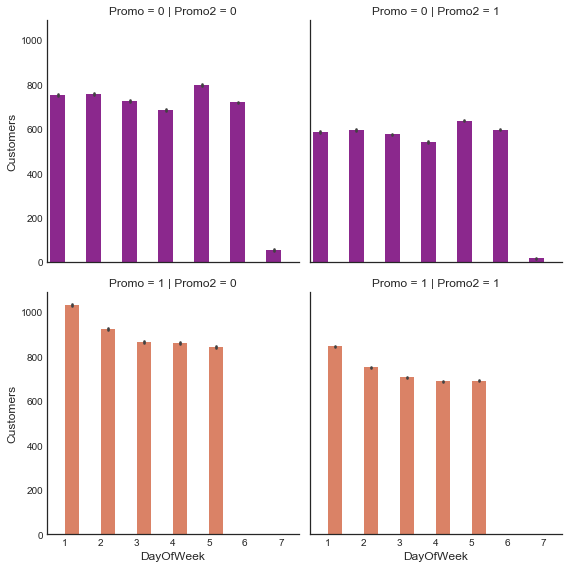

In [202]:
sns.factorplot(data = train_data, x = 'DayOfWeek', y = "Customers", 
               col = 'Promo2', 
               palette = 'plasma',
               hue = 'Promo',
               row = 'Promo',kind='bar')

In [159]:
#sns.distplot(train_data['CompetitionMonthDuration'])
#train_data[train_data['CompetitionMonthDuration']<0.0]
#sns.pairplot(train_data[train_data['StoreType']=='b' & train_data['CompetitionMonthDuration']>0 & train_data['Promo2WeekDuration']>0], vars=["Sales", "Customers","CompetitionMonthDuration","Promo2WeekDuration"])

#train_data['Sales_in_last_50']
#val_start_date = org_train_data.iloc[-1].Date - timedelta(weeks=6)
#mask = (org_train_data['Date'] >= val_start_date) & (org_train_data['Date'] <= org_train_data.iloc[-1].Date)

#split the training data and validation data
#val_data = org_train_data.loc[mask]

from pandas.plotting import autocorrelation_plot

#autocorrelation_plot(train_data[train_data.Store==1]['Sales'][2:4])
#plt.show()

#for i in range(1,len(store)+1):
#    train_data[train_data.Store==i]['Sales'].head(1)

17446752

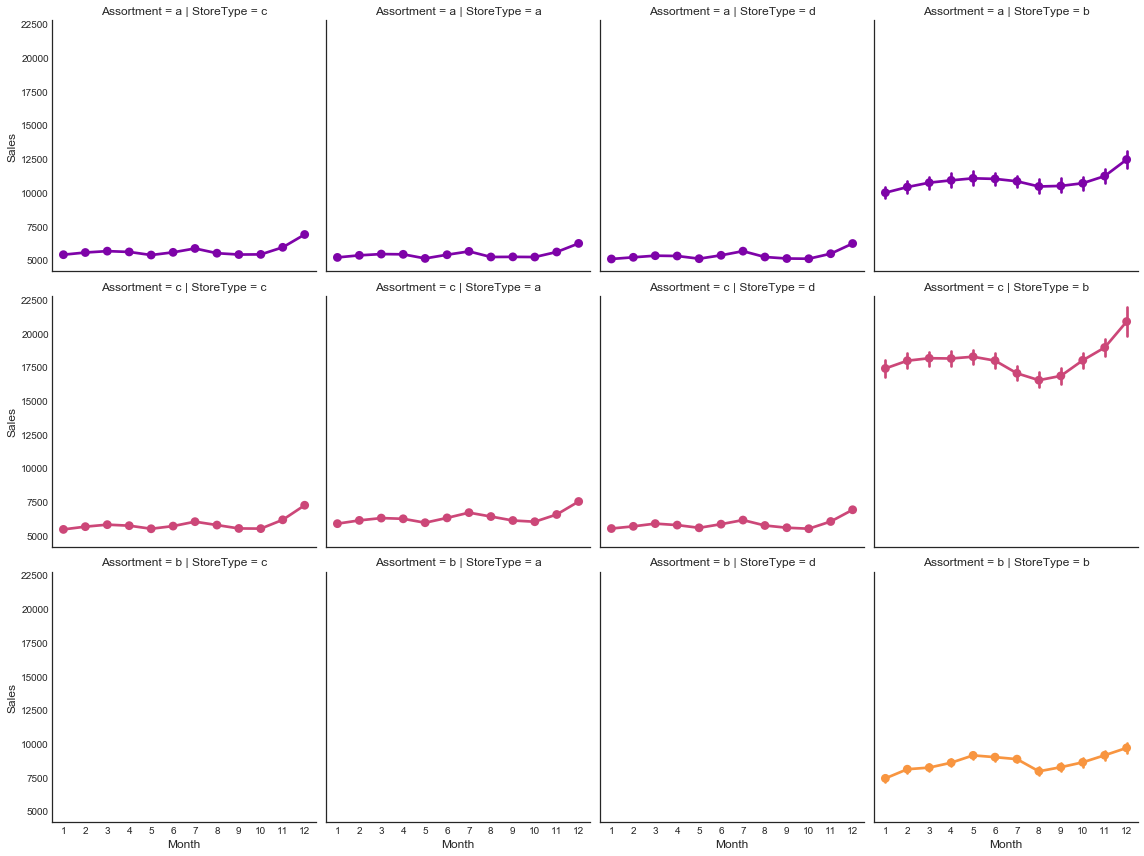

In [155]:
sns.factorplot(data = train_data, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'Assortment',
               row = 'Assortment')

       Store   DayOfWeek        Sales   Customers   Open       Promo  \
count  619.0  619.000000   619.000000  619.000000  619.0  619.000000   
mean    22.0    3.515347  4525.857835  504.247173    1.0    0.441034   
std      0.0    1.720147  1140.004611   88.307597    0.0    0.496912   
min     22.0    1.000000  2479.000000  293.000000    1.0    0.000000   
25%     22.0    2.000000  3620.000000  448.000000    1.0    0.000000   
50%     22.0    3.000000  4311.000000  504.000000    1.0    0.000000   
75%     22.0    5.000000  5255.500000  563.000000    1.0    1.000000   
max     22.0    6.000000  9437.000000  989.000000    1.0    1.000000   

       SchoolHoliday  
count     619.000000  
mean        0.176090  
std         0.381205  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  


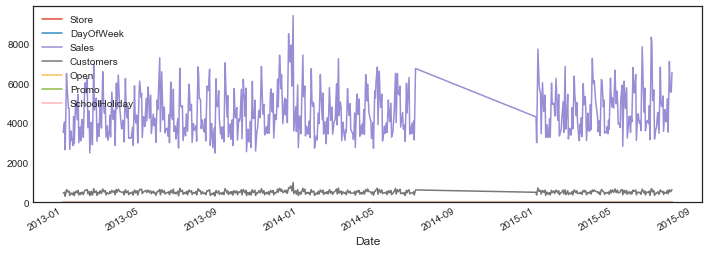

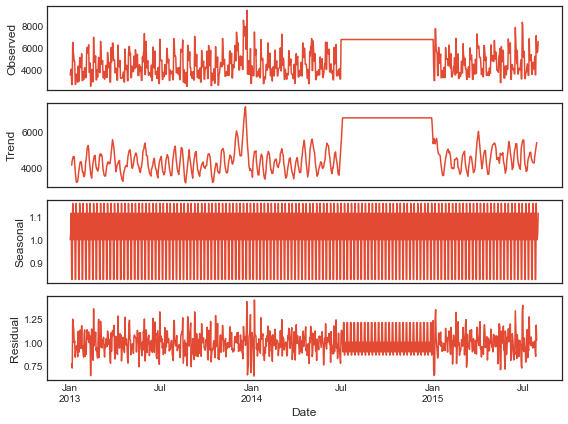

In [450]:
_,ax = plt.subplots(figsize=(20,10))
sales = train[(train['Sales']>0) & (train['Store']==22)]
print sales.describe()
sales = sales.sort_index(ascending = True)
#sales['Date'] = pd.DatetimeIndex(sales['Date'])
#sales['Date'] = pd.to_datetime(sales['Date'])
sales.plot(figsize = (12, 4),ax=ax)
ax.set_ylim(0,)
plt.show()

#sales = sales.drop(['Date'],axis=1)

sales = sales['Sales'].asfreq('d',method='pad')

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sales, model='multiplicative')
result.plot()
plt.show()

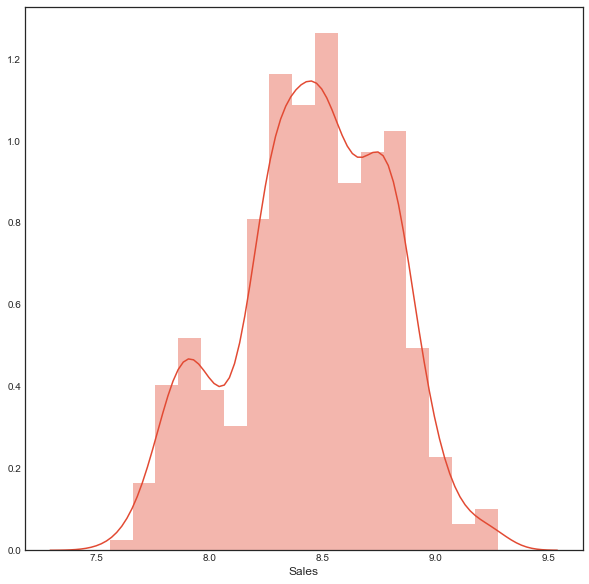

In [184]:
_,ax = plt.subplots(figsize=(10,10))
sns.distplot(np.log1p(sales['Sales']),ax=ax)

In [500]:
def build_features(features):
    features['Promo2SinceWeek'].fillna(0,inplace=True)
    features['Promo2SinceYear'].fillna(0,inplace=True)
    features['PromoInterval'].fillna('n',inplace=True)
    features['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
    features['CompetitionOpenSinceYear'].fillna(0,inplace=True)
    features['StateHoliday'] = features['StateHoliday'].replace('a',1)
    features['StateHoliday'] = features['StateHoliday'].replace('b',2)
    features['StateHoliday'] = features['StateHoliday'].replace('c',3)
    features['StateHoliday'] = pd.to_numeric(features['StateHoliday'], downcast='integer')
    features['isStateHoliday'] =  features['StateHoliday'].map(lambda x: 0 if x==0 else 1)
    features = pd.get_dummies(features,columns=['DayOfWeek','StoreType','Assortment','PromoInterval'])
    features['StoreType_b'] = features['StoreType_b'].map(lambda x: x*3)
    
    features['Date'] = pd.to_datetime(features['Date'])
    features['Month'] = features['Date'].map(lambda x: x.month)
    features['Year'] = features['Date'].map(lambda x: x.year)
    features['Week'] = features['Date'].map(lambda x: x.strftime("%V"))
    features['Week']= pd.to_numeric(features['Week'], downcast='integer')
    features['Season'] = features['Date'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4)))
    
    features["CompetitionDistance"].fillna(0,inplace=True)
    features["CompetitionDistance"] = np.log1p(features["CompetitionDistance"])
    features["CompetitionMonthDuration"] = (features['Month']-features['CompetitionOpenSinceMonth'])+(features['Year']-features['CompetitionOpenSinceYear'])*12
    features["Promo2WeekDuration"] = (features['Week']-features['Promo2SinceWeek'])/4+(features['Year']-features['Promo2SinceYear'])*12
    features["CompetitionMonthDuration"].fillna(0,inplace=True)
    features["Promo2WeekDuration"].fillna(0,inplace=True)
    features["CompetitionMonthDuration"] = np.log1p(features["CompetitionMonthDuration"])
    features["Promo2WeekDuration"] = np.log1p(features["Promo2WeekDuration"])
    
    features['AllPromo'] = features.apply(lambda x: 1 if x['Promo']&x['Promo2'] else 0,axis=1)
    features['NoPromo'] = features.apply(lambda x: 1 if ~x['Promo']&~x['Promo2'] else 0,axis=1)
    
    features = features.drop(['Date','Store'],axis=1)
    if 'Customers' in features.columns:
        features = features.drop(['Customers'],axis=1)
    if 'Sales' in features.columns:
        features = features.drop(['Sales'],axis=1)
    features.fillna(0,inplace=True)
    
    return features

In [479]:
org_train_data = pd.merge(train,store,on='Store')
#org_train_data['Date'] = pd.to_datetime(org_train_data['Date'])
org_train_data.set_index(['Date','Store'],inplace=True,drop=False)
org_train_data.sort_index(inplace=True)

org_test_data = pd.merge(test,store,on='Store')
#org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
org_test_data.sort_index(inplace=True)

combine_data = org_train_data.copy()
combine_data = org_train_data.append(org_test_data)

new_combine_data = pd.DataFrame([])

for i in range(1,len(store)+1):
    temp_data = combine_data[combine_data.Store==i].copy()
    # lags of series
    for j in range(49, 61):
        temp_data["lag_{}".format(j)] = combine_data[combine_data.Store==i]['Sales'].shift(j)
    for j in range(49, 61):
        temp_data['lag_{}_customers'.format(j)] = combine_data[combine_data.Store==i]['Customers'].shift(j)
    for j in range(49, 61):
        temp_data["ma_{}_mean".format(j)] = combine_data[combine_data.Store==i]['Sales'].shift(j).rolling(7).mean()
    new_combine_data = pd.concat([new_combine_data,temp_data],axis=0)

In [480]:
display((new_combine_data))

,,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Date,DayOfWeek,Id,Open,Promo,...,lag_51_customers,lag_52_customers,lag_53_customers,lag_54_customers,lag_55_customers,lag_56_customers,lag_57_customers,lag_58_customers,lag_59_customers,lag_60_customers
Date,Store,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,a,1270.0,9.0,2008.0,0.0,2013-01-01,2,NaN,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,1,a,1270.0,9.0,2008.0,668.0,2013-01-02,3,NaN,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,1,a,1270.0,9.0,2008.0,578.0,2013-01-03,4,NaN,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,1,a,1270.0,9.0,2008.0,619.0,2013-01-04,5,NaN,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,1,a,1270.0,9.0,2008.0,635.0,2013-01-05,6,NaN,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-06,1,a,1270.0,9.0,2008.0,0.0,2013-01-06,7,NaN,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,1,a,1270.0,9.0,2008.0,785.0,2013-01-07,1,NaN,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,1,a,1270.0,9.0,2008.0,654.0,2013-01-08,2,NaN,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-09,1,a,1270.0,9.0,2008.0,626.0,2013-01-09,3,NaN,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [502]:
new_combine_data['Id'] = pd.to_numeric(new_combine_data['Id'],downcast='integer')

for i in range(49, 61):
    lagname = "lag_{}".format(i)
    new_combine_data = new_combine_data[new_combine_data[lagname].notnull()]
    
from datetime import datetime
test_start_date = '2015-08-01'
test_start_date = datetime.strptime(test_start_date,'%Y-%m-%d')

org_train_data = new_combine_data[new_combine_data.Date<test_start_date].drop(['Id'],axis=1)
org_test_data = new_combine_data[new_combine_data.Date>=test_start_date]

org_test_data ['Id'] = pd.to_numeric(new_combine_data['Id'],downcast='integer')


In [483]:
val_start_date = org_train_data.iloc[-1].Date - timedelta(weeks=6)
mask = (org_train_data['Date'] >= val_start_date) & (org_train_data['Date'] <= org_train_data.iloc[-1].Date)

#split the training data and validation data
val_data = org_train_data.loc[mask]
train_data = org_train_data.loc[~mask]


features_train = train_data[train_data['Sales']!=0].drop('Sales',axis=1)
sales_train = np.log1p(train_data[train_data['Sales']!=0]['Sales'])

features_val = val_data[val_data['Sales']!=0].drop('Sales',axis=1)
sales_val = np.log1p(val_data[val_data['Sales']!=0]['Sales'])

features_train = build_features(features_train)
features_val = build_features(features_val)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#features_train_scaled = scaler.fit_transform(features_train)
#features_val_scaled = scaler.fit_transform(features_val)

# 将'features'和'val'数据切分成训练集和测试集
#X_train, X_val, y_train, y_val = train_test_split(features_train, sales_train, test_size = 0.1,random_state = 42)

#xgdmat=xgb.DMatrix(features_train,sales_train)
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.2,
          "max_depth": 12,
          "subsample": 0.9,
          "colsample_bytree": 0.5,
          "silent": 1
          }
num_trees = 50

from xgboost import XGBRegressor 
xgb = XGBRegressor()
xgb.fit(features_train, sales_train)

#final_gb=xgb.train(params,xgdmat,num_trees,feval=rmspe_score)
#tesdmat=xgb.DMatrix(features_val)
y_pred=xgb.predict(features_val)

print rmspe_score(sales_val,y_pred)

#reg = LinearRegression()
#reg.fit(X_train,y_train)
#y_pred=reg.predict(X_val)

#print rmspe_score(y_val,y_pred)
#print reg.score(X_val,y_val)

('RMSPE', 0.019897200126254812)


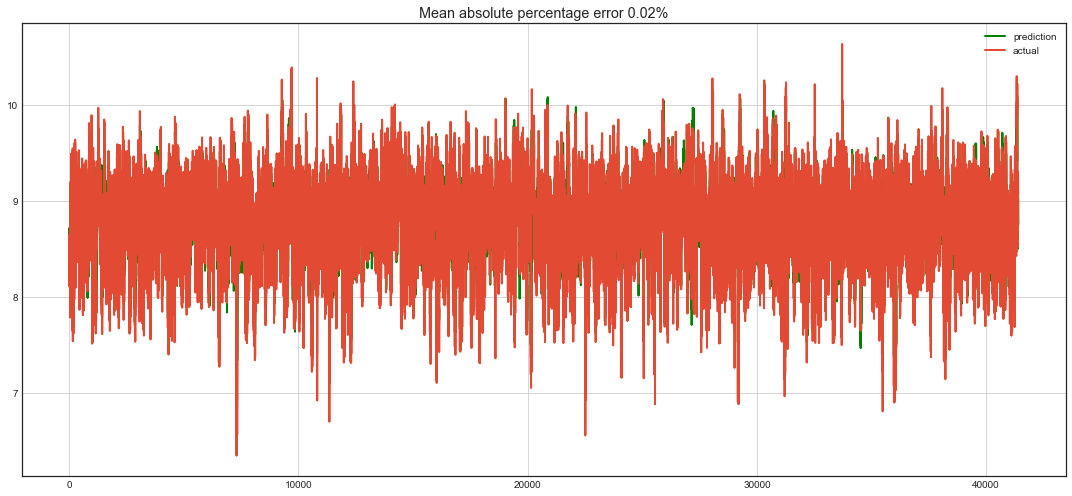

In [498]:
plotModelResults(xgb, 
                 X_train=features_train, 
                 X_test=features_val,
                 y_test=sales_val)

In [504]:
org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
org_test_data.sort_index(inplace=True)
test = build_features(org_test_data)
not_open_index = test[test['Open']==0].index
test_train = test.drop(['Id'],axis=1)
test_result = xgb.predict(test_train)
submission = pd.DataFrame({"Id": test['Id'], "Sales": np.expm1(test_result)})
submission.set_value(not_open_index,"Sales",0.0)
#submission.ix[not_open_index]["Sales"] = 0.0
submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
display(submission.ix[not_open_index])
submission.to_csv("my_submission.csv", index=False)

Id  Sales
Date       Store              
2015-08-02 1      39377    0.0
           3      39378    0.0
           7      39379    0.0
           8      39380    0.0
           9      39381    0.0
           10     39382    0.0
           11     39383    0.0
           12     39384    0.0
           13     39385    0.0
           14     39386    0.0
           15     39387    0.0
           16     39388    0.0
           19     39389    0.0
           20     39390    0.0
           21     39391    0.0
           22     39392    0.0
           23     39393    0.0
           24     39394    0.0
           25     39395    0.0
           27     39396    0.0
           29     39397    0.0
           30     39398    0.0
           31     39399    0.0
           32     39400    0.0
           33     39401    0.0
           35     39402    0.0
           36     39403    0.0
           38     39404    0.0
           39     39405    0.0
           40     39406    0.0
...                 ...    ...
2015-09-13 1100    4267    0.0
           1101    4268    0.0
           1102    4269    0.0
           1103    4270    0.0
           1104    4271    0.0
           1105    4272    0.0
           1106    4273    0.0
           1107    4274    0.0
           1109    4275    0.0
           1111    4276    0.0
           1112    4277    0.0
           1113    4278    0.0
           1114    4279    0.0
           1115    4280    0.0
2015-09-14 622     3048    0.0
           703     3112    0.0
           879     3245    0.0
           1097    3409    0.0
2015-09-15 622     2192    0.0
           703     2256    0.0
           879     2389    0.0
           1097    2553    0.0
2015-09-16 622     1336    0.0
           703     1400    0.0
           879     1533    0.0
           1097    1697    0.0
2015-09-17 622      480    0.0
           703      544    0.0
           879      677    0.0
           1097     841    0.0

[5995 rows x 2 columns]

In [ ]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
import operator

create_feature_map(features_train)
importance = final_gb.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)